In [1]:
import sys
print(f"Версия Python - {sys.version}")
print(f"Путь к интерпретатору Python - {sys.executable}")

Версия Python - 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Путь к интерпретатору Python - C:\python\python_3.10.11\python.exe


In [2]:
import pandas as pd
import numpy  as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import seaborn as sns

import pathlib

In [3]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [4]:
from tensorflow.keras import layers, activations, losses, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
import visualkeras

In [5]:
import PIL
from PIL import Image, ImageFont

import os
import re

print(os.name)  # Выведет 'nt' для Windows
import platform
print(platform.system(), platform.release(), platform.version())
import io
print("IO module path:", io.__file__)

nt
Windows 10 10.0.26100
IO module path: C:\python\python_3.10.11\lib\io.py


In [6]:
#Корректная загрузка PGM-файла формата P2 с учётом максимальной яркости пикселя
def load_raw_pgm(path):
    with open(path, 'r') as f:
        magic_number = f.readline().strip()
        while True:
            line = f.readline().strip()
            if not line.startswith('#'):
                break
        
        width, height = map(int, line.split())
        
        max_val = float(f.readline().strip())
        
        pixels = []
        for line in f:
            pixels.extend(map(float, line.split()))
        
        img = np.array(pixels, dtype=np.float32).reshape(height, width)
        return img, max_val

In [7]:
#Вывод изображений набора
def plotSetOfImages(dataArray, labelsArray):
    
    maxColInRow = 5
    nrows = dataArray.shape[0]//maxColInRow
    if dataArray.shape[0]%maxColInRow !=0:     nrows += 1
    plt.figure(figsize=(20, nrows*3 ))

    for i in range(0, 10):
        plt.subplot(nrows, maxColInRow, i+1)
        plt.axis(False)
        plt.imshow(
            dataArray[i],
            cmap='gray'
          )
        plt.title(f"№{i},y={class_names[labelsArray[i]][0:4]}")
        plt.subplots_adjust(wspace=0.1, hspace=0.3)

In [44]:
#Отображение матрицы ошибок в графическом виде
def calcAndPlotConfusionMatrix (y_test_all_labels, y_pred_all_labels, class_names=None):
    
    cm = tf.math.confusion_matrix(
        labels      =y_test_all_labels,
        predictions =y_pred_all_labels,
    ).numpy()
    cmStr = cm.astype('str')
    cmStr [cmStr =='0'] = ''

    print(cm)
    plt.figure(figsize=[5,5])
    ax= sns.heatmap(
                data=cm,
                cmap="rocket_r",
                annot=cmStr,  fmt='s',
                annot_kws={"size": 10}, square = True)
    ax.set_xlabel('Вычисленный класс')
    ax.set_ylabel('Ожидаемый класс')
    ax.set_title(f'Матрица ошибок. {len(totalHistoryLossTrain) - 2} эпох')
    if class_names!=None:
      ax.set_xticklabels(class_names)
      ax.set_yticklabels(class_names)
    plt.xticks(rotation=70)
    plt.yticks(rotation=0)
    plt.show()

In [9]:
#Аугментации для 1 класса
@tf.function
def augmentClass1(image):    
    horizontal_flip_image = tf.image.flip_left_right(image)
    vertical_flip_image = tf.image.flip_up_down(image)
    all_flip_image = tf.image.flip_up_down(tf.image.flip_left_right(image))
    
    return [horizontal_flip_image, vertical_flip_image, all_flip_image]

In [10]:
#Аугментации для 0 класса
@tf.function
def augmentClass0(image):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_flip_left_right(image)
    else:
        image = tf.image.random_flip_up_down(image)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.rot90(image, k=2)

    if tf.random.uniform(()) > 0.7:
        mask = tf.random.uniform(tf.shape(image)) < 0.1
        image = tf.where(mask, 0.0, image)
    
    return image

In [11]:
pathFotImgs = 'D:\\images'
fullPathFotImgs =  os.path.join(os.getcwd(), pathFotImgs)
print(f'Путь к директории  "{pathFotImgs}"')
print(f'Полный путь к директории  "{fullPathFotImgs}"')
assert not bool(re.search('[а-яА-Я]', fullPathFotImgs)), f'Полный путь к директории для поиска изображений ДОЛЖЕН СОДЕРЖАТЬ ТОЛЬКО ЛАТИНСКИЕ БУКВЫ. Не используйте кириллицу.'

Путь к директории  "D:\images"
Полный путь к директории  "D:\images"


In [12]:
print('==Список найденных подпапок для классов==')
for name in os.listdir(fullPathFotImgs):
    if os.path.isdir(os.path.join(fullPathFotImgs, name)):
        print ('  -', name)
print()
print('==Список найденных не распределённых изображений==')
for name in os.listdir(fullPathFotImgs):
    if os.path.isfile(os.path.join(fullPathFotImgs, name)):
        print ('  -', name)

==Список найденных подпапок для классов==
  - 0
  - 1

==Список найденных не распределённых изображений==


In [13]:
data_dir = pathlib.Path(pathFotImgs)
image_count = len(list(data_dir.glob('*/*.*')))
print('Количество найденных файлов, распределённых по подпапкам:', image_count)

for i, imgPath in enumerate(list(data_dir.glob('*/*.*'))):
    print(f'{i: >3}', imgPath)

Количество найденных файлов, распределённых по подпапкам: 1369
  0 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000000.pgm
  1 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000007.pgm
  2 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000012.pgm
  3 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000016.pgm
  4 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000017.pgm
  5 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000021.pgm
  6 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000025.pgm
  7 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000028.pgm
  8 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000037.pgm
  9 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_00000044.pgm
 10 D:\images\0\0_25ns_max_gain_phase_-0(ot max)_5360-Urf (DO BILO_5500)_0000

In [14]:
image_paths = []
labels_list = []

for label_name in sorted(os.listdir(pathFotImgs)):
    label_path = os.path.join(pathFotImgs, label_name)
    if os.path.isdir(label_path):
        label = int(label_name)
        for filename in os.listdir(label_path):
            if filename.endswith(('.pgm', '.npy')):
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)
                labels_list.append(label)

In [15]:
# Загрузка изображений
ORIG_W, ORIG_H = 1280, 960
RESIZE_W, RESIZE_H = 256, 256
MAX_BRIGHTNESS_NPY = 255.0

images = []
for path in image_paths:
    if path.endswith('.pgm'):
        img, max_val = load_raw_pgm(path)
        img = img.astype(np.float32) / max_val
    else:
        img = np.load(path)
        img = img.astype(np.float32) / MAX_BRIGHTNESS_NPY

    img = cv2.resize(img, (RESIZE_W, RESIZE_H), interpolation=cv2.INTER_LINEAR)
    images.append(img)

images = np.array(images)
labels = np.array(labels_list, dtype=np.int32)

images = tf.convert_to_tensor(images, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.int32)

print('Тип данных структуры images ', type(images))
print('Тип данных структуры labels ', type(labels))

class_names = sorted(os.listdir(pathFotImgs))
print('\nУникальных классов:', class_names)
print('Распределение меток классов:\n', labels)

print(f'\nimages.shape: {images.shape} Размер после обработки')

Тип данных структуры images  <class 'tensorflow.python.framework.ops.EagerTensor'>
Тип данных структуры labels  <class 'tensorflow.python.framework.ops.EagerTensor'>

Уникальных классов: ['0', '1']
Распределение меток классов:
 tf.Tensor([0 0 0 ... 1 1 1], shape=(1369,), dtype=int32)

images.shape: (1369, 256, 256) Размер после обработки


In [16]:
images_0 = images[labels == 0]
images_1 = images[labels == 1]

target_count = images_1.shape[0] * 4
current_count_0 = images_0.shape[0]
current_count_1 = images_1.shape[0]
aug_count_0 = target_count - current_count_0
aug_count_1 = target_count - current_count_1

print(f'Нужно дополнительно {aug_count_0} изображений для класса 0')
print(f'Нужно дополнительно {aug_count_1} изображений для класса 1')

Нужно дополнительно 4381 изображений для класса 0
Нужно дополнительно 3450 изображений для класса 1


In [17]:
#Увеличиваем набор данных с помощью аугментаций
augmented_images_0 = []
augmented_images_1 = []

for i in range(aug_count_0):
    idx = np.random.randint(0, current_count_0)
    img = images_0[idx]
    img = tf.expand_dims(img, axis=-1)
    img_aug = augmentClass0(img)
    img_aug = tf.squeeze(img_aug, axis=-1)
    augmented_images_0.append(img_aug)

for i in range(current_count_1):
    img = images_1[i]
    img = tf.expand_dims(img, axis=-1)
    imgs_aug = augmentClass1(img)

    for img_aug in imgs_aug:
        img_aug = tf.squeeze(img_aug, axis=-1)
        augmented_images_1.append(img_aug)

images_balanced_0 = tf.concat([images_0, tf.stack(augmented_images_0)], axis=0)
labels_balanced_0 = tf.zeros([target_count], dtype=tf.int32)

images_balanced_1 = tf.concat([images_1, tf.stack(augmented_images_1)], axis=0)
labels_balanced_1 = tf.ones([target_count], dtype=tf.int32)

# Объединяем оба класса
images_balanced = tf.concat([images_balanced_0, images_balanced_1], axis=0)
labels_balanced = tf.concat([labels_balanced_0, labels_balanced_1], axis=0)

count_class_0 = tf.reduce_sum(tf.cast(labels_balanced == 0, tf.int32))
count_class_1 = tf.reduce_sum(tf.cast(labels_balanced == 1, tf.int32))

print(f'Количество объектов в классе 0: {count_class_0.numpy()}')
print(f'Количество объектов в классе 1: {count_class_1.numpy()}')

Количество объектов в классе 0: 4600
Количество объектов в классе 1: 4600


In [18]:
#Приведение к numpy.ndarray
images = images_balanced.numpy() ; print('Тип данных структуры images ', type(images))
labels = labels_balanced.numpy() ; print('Тип данных структуры labels ', type(labels))

valid_size = 0.2
rand_seed = 1

X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size    = valid_size,
    random_state = rand_seed,
    shuffle=True,
    stratify=labels,
)

Тип данных структуры images  <class 'numpy.ndarray'>
Тип данных структуры labels  <class 'numpy.ndarray'>


In [19]:
print ("Кол-во образцов: "
       "\n  X_train : {:>3}, y_train {:>3} "
       "\n  X_test  : {:>3}, y_test  {:>3} "
       "\n  X всего : {:>3}, y всего {:>3} ".format  (
    len(X_train), len(y_train),
    len(X_test),  len(y_test),
    len(X_train)+len(X_test), len(y_train)+len(y_test),
))

Кол-во образцов: 
  X_train : 7360, y_train 7360 
  X_test  : 1840, y_test  1840 
  X всего : 9200, y всего 9200 


Обучающая часть.
[0 0 1 ... 0 1 0]
Изображений в наборе 7360:
  Класс_0, кол-во 3680 шт.
  Класс_1, кол-во 3680 шт.


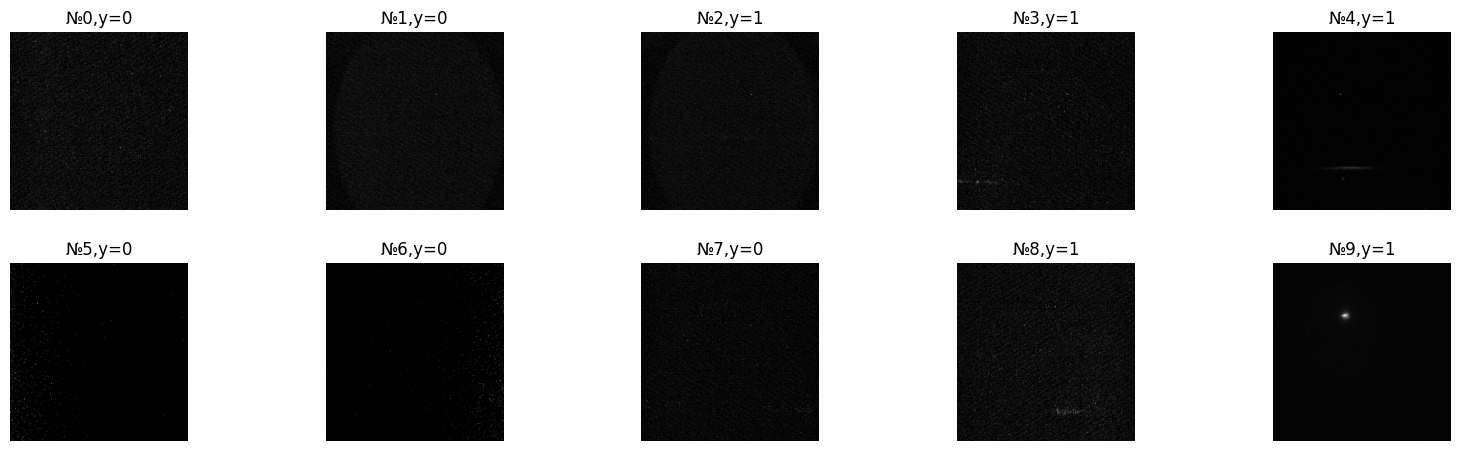

In [20]:
print("Обучающая часть.")
print(y_train)

print(f"Изображений в наборе {y_train.shape[0]}:")
for class_label, count in zip (*np.unique(y_train, return_counts=True)):
    print(f'  Класс_{class_label}, кол-во {count:>3} шт.' )

# Вывод изображений набора в графическом виде
plotSetOfImages(X_train, y_train)

Проверочная часть.
[0 1 0 ... 0 0 0]
Изображений в наборе 1840:
  Класс_0, кол-во 920 шт.
  Класс_1, кол-во 920 шт.


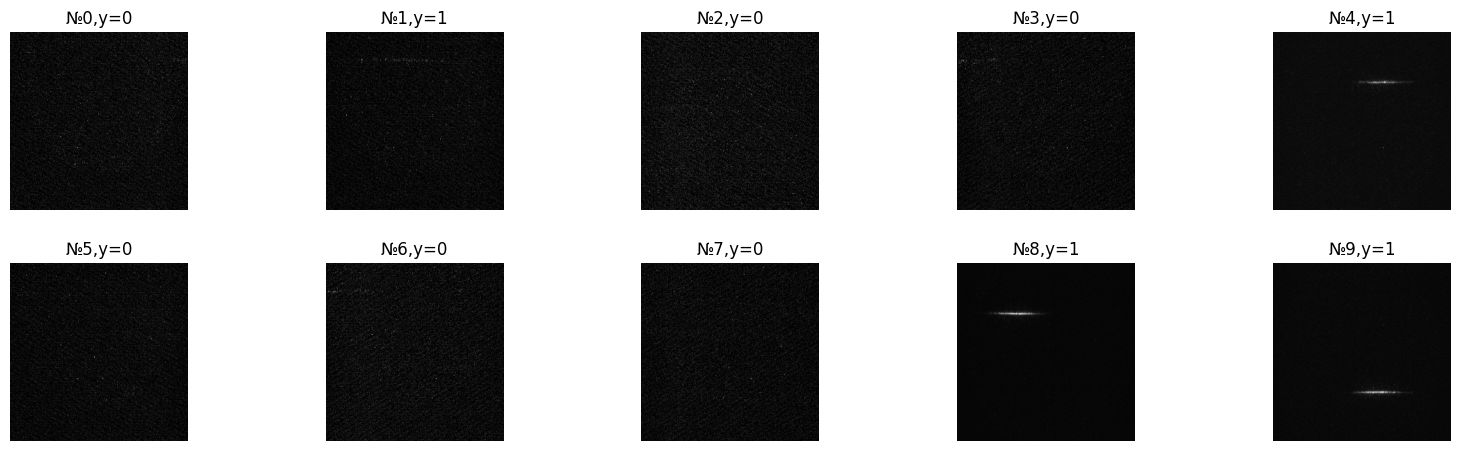

In [21]:
print("Проверочная часть.")
print(y_test)

print(f"Изображений в наборе {y_test.shape[0]}:")
for class_label, count in zip (*np.unique(y_test, return_counts=True)):
    print(f'  Класс_{class_label}, кол-во {count:>3} шт.' )

# Вывод изображений набора в графическом виде
plotSetOfImages(X_test, y_test)

In [29]:
#Построение модели CNN
model = tf.keras.Sequential()

model.add(
    layers.Input(
        shape=(256,256,1) ))

model.add(
    layers.Conv2D      (
         filters=32,
         kernel_size=(5, 5,),
         strides=1 ,
         padding='same',
         activation=activations.relu,  ))

model.add(
    layers.MaxPooling2D(
        pool_size=( 5, 5,),
        strides= 2,))

model.add(
    layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides=1,
        padding='same',
        activation=activations.relu))

model.add(
    layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2))

model.add( layers.Flatten())

model.add(
    layers.Dense(
        units= 256,
        activation= activations.relu, ))

model.add(
    layers.Dense(
        units= 128,
        activation= activations.relu, ))

model.add(layers.Dropout(0.3))

model.add(
    layers.Dense(
        units= 1,
        activation= activations.sigmoid  ))

In [30]:
#Функции потерь и функции оптимизации
fLoss      = losses.BinaryCrossentropy()
fOptimizer = optimizers.Adam(learning_rate=0.001)
fMetric    = [ metrics.BinaryAccuracy(),]

In [31]:
totalHistoryLossTrain=list()
totalHistoryLossTest =list()
globalEpochCounter = 1
fullFitTime = 0.0 

#Инициализация модели
model.compile(
    loss      = fLoss,
    optimizer = fOptimizer,
    metrics   = fMetric
)
print("Вывод короткой информации о структуре НС")
model.summary()

Вывод короткой информации о структуре НС


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 254016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      65,028,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,080,705 (248.26 MB)

 Trainable params: 65,080,705 (248.26 MB)

 Non-trainable params: 0 (0.00 B)

C:\python\python_3.10.11\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


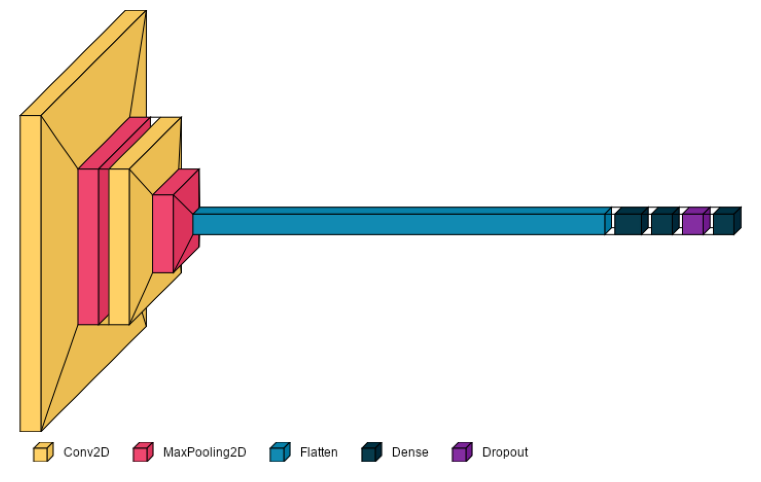

In [32]:
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(
    model,
    legend=True,
    font=font,
    spacing=10, 
    scale_xy=1.2,
).save("model_image.png")
img = PIL.Image.open("model_image.png")
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
#Ранняя остановка, чтобы модель не переобучилась
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2, # Количество эпох без улучшения перед остановкой
    restore_best_weights=True
)

history = model.fit(
    x=X_train,
    y=y_train,
    epochs= 10,
    batch_size=50,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Сбор и дополнение полной истории обучения
totalHistoryLossTrain.extend(history.history['loss'])
if 'val_loss' in history.history.keys():
    totalHistoryLossTest.extend(history.history['val_loss'])

print(f"Обучение остановлено на эпохе {len(history.history['loss'])}")
print(f"Лучшие потери на валидации: {min(history.history['val_loss'])}")

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 144s 967ms/step - binary_accuracy: 0.7474 - loss: 0.4777 - val_binary_accuracy: 0.9321 - val_loss: 0.1704
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 143s 968ms/step - binary_accuracy: 0.9540 - loss: 0.1299 - val_binary_accuracy: 0.9554 - val_loss: 0.1133
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 144s 976ms/step - binary_accuracy: 0.9739 - loss: 0.0741 - val_binary_accuracy: 0.9804 - val_loss: 0.0588
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 143s 966ms/step - binary_accuracy: 0.9823 - loss: 0.0448 - val_binary_accuracy: 0.9793 - val_loss: 0.0559
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 144s 972ms/step - binary_accuracy: 0.9853 - loss: 0.0426 - val_binary_accuracy: 0.9734 - val_loss: 0.0895
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 143s 966ms/step - binary_accuracy: 0.9839 - loss: 0.0421 - val_binary_accuracy: 0.9837 - val_loss: 0.0531
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 143s 968ms/step - binary_accuracy: 0.9853 - loss: 0.0409 - val_binary_accuracy: 0.98

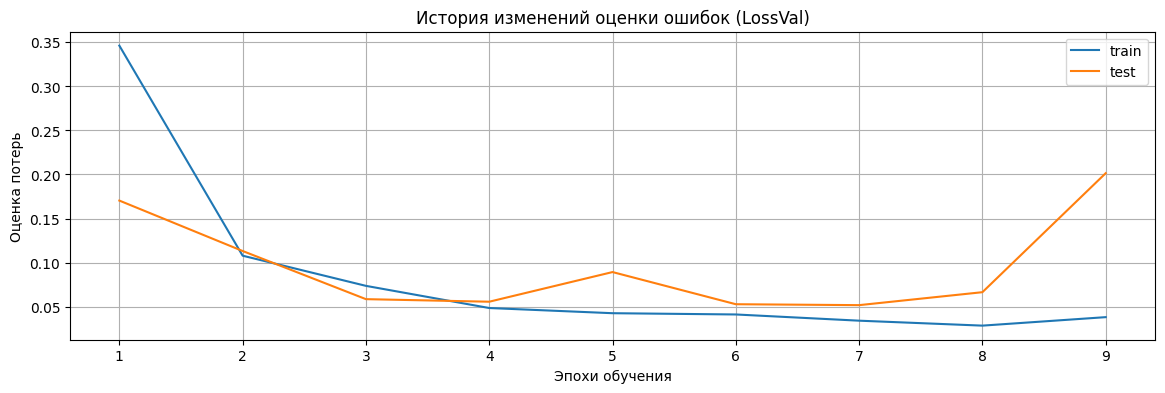

In [34]:
# Отобразить график изменения оценки потерь по эпохам обучения
plt.figure(figsize=(14,4))
plt.plot(totalHistoryLossTrain, label='train')
if 'val_loss' in history.history.keys():
    plt.plot(totalHistoryLossTest, label='test')
num_epochs = len(totalHistoryLossTrain)
plt.xticks(range(num_epochs), range(1, num_epochs + 1))
plt.legend()
plt.title("История изменений оценки ошибок (LossVal)")
plt.ylabel("Оценка потерь")
plt.xlabel("Эпохи обучения")
plt.grid()

In [35]:
print('Вычисление ответов - вызов model.predict(X)')
y_pred_all_probability = model.predict(X_test)

Вычисление ответов - вызов model.predict(X)
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step


In [36]:
print(f'\nОтветы модели (вероятности принадлежности) на все предъявленные образцы (отображено для первых 5):')
pd.DataFrame(y_pred_all_probability).round(2)[:5]


Ответы модели (вероятности принадлежности) на все предъявленные образцы (отображено для первых 5):


,0
0,0.0
1,1.0
2,0.0
3,0.4
4,1.0


In [56]:
print(f'\nВычисленные метки классов y_pred_all:\nПолучить из вероятностей заключения - номер класса с максимальной вероятностью (отображено для первых 5 изображений)')
y_pred_all_labels = (y_pred_all_probability > 0.5).astype(int).flatten()
print('Вычисленые метки классов для первых ')
y_pred_all_labels[:5]


Вычисленные метки классов y_pred_all:
Получить из вероятностей заключения - номер класса с максимальной вероятностью (отображено для первых 5 изображений)
Вычисленые метки классов для первых 


array([0, 1, 0, 0, 1])

In [57]:
print(f'\nОжидаемые метки классов y_train:\nПолучить из вероятностей заключения - номер класса с максимальной вероятностью (отображено для первых 5 изображений)')
y_test_all_labels = y_test.flatten()
y_test_all_labels[:5]


Ожидаемые метки классов y_train:
Получить из вероятностей заключения - номер класса с максимальной вероятностью (отображено для первых 5 изображений)


array([0, 1, 0, 0, 1])

Ожидаемые/проверочные метки классов:
 [0 1 0 ... 0 0 0] 

Вычисленные метки классов:
 [0 1 0 ... 0 0 0] 

[[916   4]
 [ 22 898]]


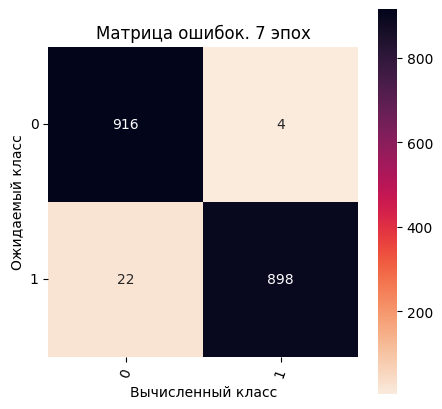

In [58]:
print('Ожидаемые/проверочные метки классов:\n', y_test_all_labels,'\n')
print('Вычисленные метки классов:\n',           y_pred_all_labels,'\n')

calcAndPlotConfusionMatrix (
    y_test_all_labels,
    y_pred_all_labels,
    class_names
)

In [59]:
print(
    classification_report(
      y_true= y_test_all_labels,
      y_pred= y_pred_all_labels,
      target_names=class_names,
))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       920
           1       1.00      0.98      0.99       920

    accuracy                           0.99      1840
   macro avg       0.99      0.99      0.99      1840
weighted avg       0.99      0.99      0.99      1840



In [60]:
model.save('model.keras')

In [63]:
mask = np.not_equal(y_test_all_labels, y_pred_all_labels)
indexesAll = np.arange(len(y_test_all_labels))
indexesWrongPredict = indexesAll[mask]

print(f'Кол-во ошибочных ответов модели: {len(indexesWrongPredict)}\n')

print('Образцы с ошибочно вычисленным классом:')
print('Изобр. № | Истинный | Вычисленный')
for i, imgNum in enumerate(indexesWrongPredict):
    yi_true = y_test_all_labels[imgNum]
    yi_pred = y_pred_all_labels[imgNum]
    print(f'{imgNum:>7} | {yi_true:>8} | {yi_pred:>10}')

Кол-во ошибочных ответов модели: 26

Образцы с ошибочно вычисленным классом:
Изобр. № | Истинный | Вычисленный
     23 |        1 |          0
     66 |        1 |          0
    109 |        1 |          0
    198 |        1 |          0
    398 |        1 |          0
    425 |        1 |          0
    445 |        1 |          0
    471 |        1 |          0
    513 |        1 |          0
    566 |        1 |          0
    684 |        1 |          0
    699 |        1 |          0
    734 |        1 |          0
   1027 |        1 |          0
   1043 |        1 |          0
   1060 |        1 |          0
   1193 |        0 |          1
   1213 |        1 |          0
   1219 |        1 |          0
   1257 |        0 |          1
   1258 |        1 |          0
   1419 |        1 |          0
   1447 |        1 |          0
   1493 |        1 |          0
   1576 |        0 |          1
   1683 |        0 |          1
